# The Pacanowski-Philander parameterization in `OceanTurb.jl`

Here we demonstrate using the Pacanowski-Philander parameterization in `OceanTurb.jl`.

In [1]:
using Pkg; Pkg.activate(".."); Pkg.instantiate()

using OceanTurb, PyPlot, PyPlotPlus

import PyPlot: plot

plot(f::Field, args...; kwargs...) = plot(data(f), nodes(f), args...; kwargs...)
plot(op::Function, f::Field, args...; kwargs...) = plot(op.(data(f)), nodes(f), args...; kwargs...)

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Info: Recompiling stale cache file /Users/gregorywagner/.julia/compiled/v1.0/OceanTurb/9iboO.ji for OceanTurb [d848d694-35fd-11e9-1c91-9995598ac29e]
└ @ Base loading.jl:1187


plot (generic function with 3 methods)

# Kato and Phillips (1969)

We now attempt to reproduce the experimental results of Kato and Phillips, 
["On the penetration of a turbulent layer into stratified fluid"](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/on-the-penetration-of-a-turbulent-layer-into-stratified-fluid/1D763D80170943E6FFA0573DFE20F091) JFM (1969).

In these experiments, a constant stress at the surface of a linearly stratified fluid
drives turbulence that gradually penetrates deeper into the fluid. 

In [42]:
# First, we define the model.
parameters = PacanowskiPhilander.Parameters(κ₀=1e-7, ν₀=1e-6) # use molecular values.
constants = Constants(f=0)
model = PacanowskiPhilander.Model(N=30, L=0.28, parameters=parameters, constants=constants)

# Initial condition
ρz = -0.000192 * 1e-3 / 1e-8 # convert from cgs to kg/m^4
ρ₀ = 1.000 * 1e-3 / 1e-6 # convert from cgs to kg/m^3
Tz = -ρz / (constants.α * ρ₀) # ρ'/ρ₀ = 1 - α(T-T₀)
T₀(z) = Tz*z

# Set T to the function T0(z)
model.solution.T = T₀

τ = 0.995 * 1e-3 / 1e-2 # convert: ρ Fᵤ = [kg / m^3 * m^2/s^2] = kg / m-s^2
momentum_flux = -τ / ρ₀
model.bcs.U.top = FluxBoundaryCondition(momentum_flux)
model.bcs.T.bottom = GradientBoundaryCondition(Tz);

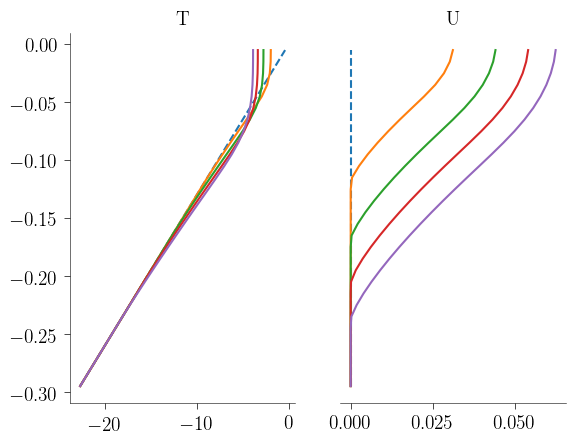

In [43]:
model.solution.T = T₀
model.solution.U = 0
model.solution.V = 0
model.solution.S = 0

U, V, T, S = model.solution

# Initialize plotting
fig, axs = subplots(ncols=2)
ax1 = get(axs, 0)
ax2 = get(axs, 1)

sca(ax1)
plot(T, "--", label="initial condition")
title("T")
cornerspines()

sca(ax2)
plot(U, "--", label="initial condition")
title("U")
bottomspine()
ax2.tick_params(left=false, labelleft=false)

dt = 1e-4
ni = Int(2*10^5)

for i = 1:4
    iterate!(model, dt, ni)
    
    sca(ax1)
    plot(T, "-")
    
    sca(ax2)
    plot(U, "-")
end